<a href="https://colab.research.google.com/github/AditPradana36/facade_dominant_color_extraction/blob/main/facade_dominant_color_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facade Dominant Color Extraction through Street-View Imagery (SVI)
This script extracts the dominant facade colors of buildings based on Street-View Imagery (SVI). Building facades are segmented using a pre-trained model. The color scheme used for analysis is HSV, where H represents Hue (0–179), S is Saturation (0–1), and V is Value (0–1).

The script produces the following outputs:
1. Segmented images of building facades (.jpg)
2. A CSV file indicating whether the dominant facade color leans toward warm or cold hues
3. A CSV file showing the dominant color proportions in HSV space using K-Means clustering

Notes:
- Use a GPU-enabled runtime
- Ensure that the SVI data is stored in a designated path on Google Drive
- This code developed in Google Colab Environment

This code modifies parts of the implementation by Zhou et al. (2019):
https://github.com/CSAILVision/semantic-segmentation-pytorch

— Mohammad Raditia Pradana @2025



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### This pre-trained semantic segmentation model was provided by Zhou et al. (2019).
For more details about the model, please visit: https://github.com/CSAILVision/semantic-segmentation-pytorch

In [ ]:
%%bash
# Colab-specific setup
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
From https://github.com/CSAILVision/semantic-segmentation-pytorch
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


In [ ]:
# ==== System and External Libraries ====
import os
import csv
import numpy as np
import pandas as pd
import torch
import scipy.io
import PIL
from PIL import Image
import cv2
import torchvision
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# ==== MIT Semantic Segmentation Modules ====
from mit_semseg.models import ModelBuilder, SegmentationModule  # Wrapper for the segmentation model from MIT CSAIL
from mit_semseg.utils import colorEncode  # Convert label map to RGB using predefined color codes

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)  # Convert label map to RGB using predefined color codes

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

In [ ]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)  # Wrapper for the segmentation model from MIT CSAIL
segmentation_module.eval()
segmentation_module.cuda()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

In [ ]:
# Function to load and normalize image
def load_and_normalize_image(image_path):
    pil_to_tensor = torchvision.transforms.Compose([  # Define preprocessing pipeline for image
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])
    pil_image = PIL.Image.open(image_path).convert('RGB')  # Open image using PIL
    img_data = pil_to_tensor(pil_image)
    return img_data, np.array(pil_image)

# Segmentation Process
Output:
1. Segmented images of building facades (.jpg)
2. A CSV file indicating whether the dominant facade color leans toward warm or cold hues

In [ ]:
# Directories
image_directory = 'YOUR SVI PATH' # <-- Change with your path
output_directory = 'EXPECTED SEGMENTED IMAGE DIRECTORY (OUTPUT)' # <-- Change with your path
output_csv_path = os.path.join(output_directory, "building_hue_stats.csv")

os.makedirs(output_directory, exist_ok=True)

# Target building-like labels (as written in object150_info.csv)
target_labels = ['building', 'house', 'skyscraper', 'tower']
target_indices = [k - 1 for k, v in names.items() if v in target_labels]  # ADE20K class indices start at 1

# Storage
results = []

# Get image list
image_files = [f for f in os.listdir(image_directory) if os.path.isfile(os.path.join(image_directory, f))]

for image_file in image_files:
    image_path = os.path.join(image_directory, image_file)

    # Load and normalize image
    img_data, img_original = load_and_normalize_image(image_path)
    img_tensor = torch.tensor(img_data).to(device)

    # Batchify and infer
    singleton_batch = {'img_data': img_tensor.unsqueeze(0)}
    output_size = img_tensor.shape[1:]

    with torch.no_grad():
        scores = segmentation_module(singleton_batch, segSize=output_size)
        _, pred = torch.max(scores, dim=1)
        pred = pred.cpu().numpy()[0]

    # === BUILDING MASKING & HUE EXTRACTION ===
    mask = np.isin(pred, target_indices)
    img_hsv = cv2.cvtColor(img_original, cv2.COLOR_RGB2HSV)  # Convert image color space (e.g., BGR to RGB or LAB)
    hue_channel = img_hsv[:, :, 0]
    valid_hue = hue_channel[mask]

    if valid_hue.size == 0:
        warm_pixel = cool_pixel = total_pixel = 0
    else:
        warm_mask = (valid_hue <= 34) | (valid_hue >= 150)
        cool_mask = (valid_hue >= 35) & (valid_hue <= 149)

        warm_pixel = int(np.sum(warm_mask))
        cool_pixel = int(np.sum(cool_mask))
        total_pixel = warm_pixel + cool_pixel  # Excludes no pixel


    # Save masked image
    masked_img = img_original.copy()
    masked_img[~mask] = [0, 0, 0]
    save_path = os.path.join(output_directory, f"masked_building_{image_file}")
    PIL.Image.fromarray(masked_img).save(save_path)

    # Point ID
    pointID = '_'.join(image_file.split('_')[1:3])  # adjust if needed

    # Append result
    results.append({
        "ID": pointID,
        "Image": image_file,
        "pixel_building": int(valid_hue.size),
        "warm_pixel": int(warm_pixel),
        "cool_pixel": int(cool_pixel)
    })

# Export result
df = pd.DataFrame(results)
df.to_csv(output_csv_path, index=False)
print(f"Saved to {output_csv_path}")

/tmp/ipython-input-13-3005198150.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(img_data).to(device)


Saved to /content/drive/MyDrive/ZenSVI_TRIAL/hue_trial/huegvi/building_hue_stats.csv


In [ ]:
df = pd.read_csv(output_csv_path)
df.head(10)

,ID,Image,pixel_building,warm_pixel,cool_pixel
0,4020.jpg,pointID_4020.jpg,701062,465995,235067
1,4045.jpg,pointID_4045.jpg,549422,195006,354416
2,4394.jpg,pointID_4394.jpg,245171,71066,174105
3,4317.jpg,pointID_4317.jpg,558413,212274,346139
4,4147.jpg,pointID_4147.jpg,642544,33323,609221
5,4315.jpg,pointID_4315.jpg,74762,26021,48741
6,4414.jpg,pointID_4414.jpg,371508,112780,258728
7,4004.jpg,pointID_4004.jpg,74751,26530,48221
8,4029.jpg,pointID_4029.jpg,127911,88489,39422
9,4052.jpg,pointID_4052.jpg,172565,85265,87300


# HSV Dominant Color Extraction
Output:
3. A CSV file showing the dominant color proportions in HSV space using K-Means clustering

In [ ]:
# Parameters
masked_image_dir = 'SEGMENTED IMAGE DIRECTORY (OUTPUT)' # <-- Change with your path. Must be same as output_directory
output_csv = os.path.join(masked_image_dir, "dominant_hsv_building_only.csv")
n_colors = 4  # Number of dominant HSV colors to extract

# Storage
results = []

# Loop over masked images
for fname in os.listdir(masked_image_dir):
    if not fname.lower().startswith("masked_building_") or not fname.lower().endswith((".jpg", ".png")):
        continue

    image_path = os.path.join(masked_image_dir, fname)
    img = Image.open(image_path).convert("RGB")  # Open image using PIL
    img_np = np.array(img)

    # Convert to HSV
    hsv_img = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)  # Convert image color space (e.g., BGR to RGB or LAB)
    h, w, _ = hsv_img.shape
    hsv_flat = hsv_img.reshape((-1, 3))

    # Mask out black (non-building) pixels — all channels == 0
    mask_valid = ~(np.all(img_np == [0, 0, 0], axis=-1).reshape(-1))
    hsv_filtered = hsv_flat[mask_valid]

    if hsv_filtered.shape[0] < n_colors:
        continue  # Skip if not enough pixels to cluster

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(hsv_filtered)  # Initialize KMeans clustering
    labels, counts = np.unique(kmeans.labels_, return_counts=True)

    total_pixels = np.sum(counts)
    proportions = counts / total_pixels
    centers = kmeans.cluster_centers_

    # Sort by weight
    sorted_idx = np.argsort(proportions)[::-1]

    # Record per image
    record = {"Image": fname}
    for rank, idx in enumerate(sorted_idx):
        c_label = f"C{rank+1}"
        h_val = int(centers[idx][0])
        s_val = round(centers[idx][1] / 255, 2)
        v_val = round(centers[idx][2] / 255, 2)
        record[f"{c_label}_Weight"] = round(proportions[idx], 2)
        record[f"{c_label}_HSV"] = f"({h_val}, {s_val}, {v_val})"
    results.append(record)

# Save to CSV
df = pd.DataFrame(results)
df.to_csv(output_csv, index=False)
print(f"Saved dominant color data to {output_csv}")

Saved dominant color data to /content/drive/MyDrive/ZenSVI_TRIAL/hue_trial/huegvi/dominant_hsv_building_only.csv


In [ ]:
df = pd.read_csv(output_csv)
df.head(10)

,Image,C1_Weight,C1_HSV,C2_Weight,C2_HSV,C3_Weight,C3_HSV,C4_Weight,C4_HSV
0,masked_building_pointID_4317.jpg,0.46,"(73, 0.07, 0.64)",0.28,"(61, 0.13, 0.15)",0.16,"(34, 0.44, 0.2)",0.10,"(65, 0.97, 0.02)"
1,masked_building_pointID_4315.jpg,0.33,"(58, 0.12, 0.23)",0.28,"(62, 0.08, 0.62)",0.26,"(66, 0.97, 0.01)",0.13,"(28, 0.37, 0.4)"
2,masked_building_pointID_4020.jpg,0.36,"(45, 0.09, 0.71)",0.29,"(16, 0.27, 0.33)",0.22,"(138, 0.19, 0.37)",0.13,"(65, 0.94, 0.05)"
3,masked_building_pointID_4147.jpg,0.39,"(90, 0.11, 0.89)",0.23,"(90, 0.29, 0.59)",0.20,"(79, 0.9, 0.1)",0.19,"(76, 0.32, 0.2)"
4,masked_building_pointID_4414.jpg,0.39,"(78, 0.08, 0.61)",0.32,"(29, 0.22, 0.26)",0.15,"(97, 0.16, 0.27)",0.14,"(62, 0.94, 0.03)"
5,masked_building_pointID_4394.jpg,0.34,"(103, 0.13, 0.66)",0.25,"(28, 0.12, 0.63)",0.24,"(52, 0.2, 0.25)",0.17,"(72, 0.97, 0.02)"
6,masked_building_pointID_4045.jpg,0.30,"(104, 0.11, 0.57)",0.30,"(63, 0.24, 0.24)",0.28,"(22, 0.13, 0.61)",0.12,"(62, 0.94, 0.04)"
7,masked_building_pointID_4029.jpg,0.38,"(45, 0.1, 0.66)",0.37,"(40, 0.22, 0.26)",0.16,"(27, 0.96, 0.03)",0.09,"(125, 0.95, 0.02)"
8,masked_building_pointID_4004.jpg,0.32,"(122, 0.12, 0.59)",0.29,"(116, 0.21, 0.27)",0.24,"(14, 0.18, 0.46)",0.16,"(70, 0.96, 0.02)"
9,masked_building_pointID_4409.jpg,0.31,"(22, 0.2, 0.21)",0.27,"(118, 0.19, 0.17)",0.24,"(62, 0.07, 0.58)",0.18,"(74, 0.93, 0.03)"


# Example of one SVI output

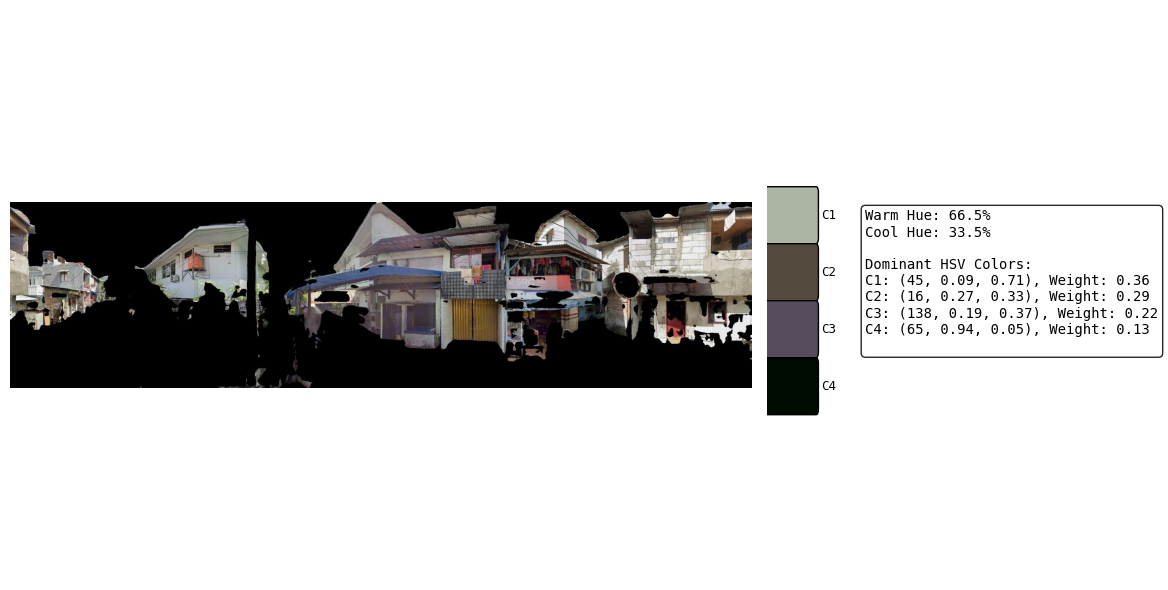

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import colorsys
from matplotlib import gridspec

# === SETTINGS ===
image_name = "XXX.jpg" # <-- Change with your path. Directly point out certain image (single segmented image)
masked_image_dir = 'SEGMENTED IMAGE DIRECTORY (OUTPUT)' # <-- Change with your path. Must be same as output_directory
hue_stats_csv = os.path.join(masked_image_dir, "building_hue_stats.csv")
dominant_csv = os.path.join(masked_image_dir, "dominant_hsv_building_only.csv")

# === LOAD CSVs ===
df_hue_stats = pd.read_csv(hue_stats_csv)
df_dominant = pd.read_csv(dominant_csv)

# === LOAD IMAGE ===
image_path = os.path.join(masked_image_dir, image_name)
image = Image.open(image_path).convert("RGB")
image_np = np.array(image)

# === MATCH FILENAME FORMAT ===
base_image_name = image_name.replace("masked_building_", "")

# === GET ATTRIBUTES FROM building_hue_stats.csv ===
hue_row = df_hue_stats[df_hue_stats["Image"] == base_image_name]
if hue_row.empty:
    raise ValueError(f"{base_image_name} not found in building_hue_stats.csv")

warm = hue_row["warm_pixel"].values[0]
cool = hue_row["cool_pixel"].values[0]
total = hue_row["pixel_building"].values[0]
warm_pct = round(warm / total * 100, 1) if total > 0 else 0
cool_pct = round(cool / total * 100, 1) if total > 0 else 0

# === GET HSV DOMINANT COLORS ===
dom_row = df_dominant[df_dominant["Image"] == image_name]
if dom_row.empty:
    dom_row = df_dominant[df_dominant["Image"] == base_image_name]
    if dom_row.empty:
        raise ValueError(f"{base_image_name} not found in dominant_hsv_building_only.csv")

dominant_info = []
for i in range(1, 5):
    hsv_col = f"C{i}_HSV"
    weight_col = f"C{i}_Weight"
    if hsv_col in dom_row and weight_col in dom_row:
        hsv_str = dom_row[hsv_col].values[0]
        weight = dom_row[weight_col].values[0]

        # Convert HSV to RGB
        hsv = eval(hsv_str)
        h = hsv[0] / 179.0
        s = hsv[1]
        v = hsv[2]
        rgb = colorsys.hsv_to_rgb(h, s, v)
        rgb255 = tuple(int(x * 255) for x in rgb)

        dominant_info.append((f"C{i}", hsv_str, weight, rgb255))

# === SETUP GRID LAYOUT (image left, info right) ===
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
ax_img = plt.subplot(gs[0])
ax_info = plt.subplot(gs[1])
ax_info.axis('off')

# === SHOW IMAGE ===
ax_img.imshow(image_np)
ax_img.axis('off')

# === TEXT INFO ===
info_text = f"Warm Hue: {warm_pct}%\nCool Hue: {cool_pct}%\n\nDominant HSV Colors:\n"
for cname, hsv_str, weight, _ in dominant_info:
    info_text += f"{cname}: {hsv_str}, Weight: {weight:.2f}\n"

ax_info.text(0.4, 0.65, info_text, transform=ax_info.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.85),
             family='monospace')

# === COLOR PATCHES ===
for idx, (cname, _, _, rgb) in enumerate(dominant_info):
    y = 0.6 - idx * 0.1
    color_patch = patches.FancyBboxPatch(
        (0, y),
        0.2, 0.08,
        boxstyle="round,pad=0.01",
        transform=ax_info.transAxes,
        facecolor=np.array(rgb) / 255,
        edgecolor='black'
    )
    ax_info.add_patch(color_patch)
    ax_info.text(0.22, y + 0.04, cname, transform=ax_info.transAxes,
                 verticalalignment='center', fontsize=9, family='monospace')

plt.tight_layout()
plt.show()
